In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib
import torch.nn.functional as F     # Contains all the functions in the torch.nn library


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [4]:
def train(inputDataLoader,model,loss_function,optimizer):
    
    model.train()
    acccs=[]
    loss_array=[]
    local_sen=[]
    for (inputs,label) in inputDataLoader:
        label=label.to(device)
        inputs = inputs.reshape(-1, 28*28).to(device)
        output=model.forward(inputs)
        loss=loss_function(output,label)
        optimizer.zero_grad()
        grads_p = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
        local_sen.append(grads_p.norm(2).detach().cpu().item())
        loss.backward()
        optimizer.step()
        loss_array.append(loss.detach().cpu().numpy())
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        # measure accuracy and record loss
        acc1 = accuracy(preds, labels)
        acccs.append(acc1)
    return np.mean(acccs),np.mean(loss_array),np.mean(local_sen)

In [5]:
def test(inputDataLoader,model,loss_function,optimizer):
    model.eval()
    output_result=[]
    loss_array=[]
    acccs=[]
    with torch.no_grad():
        for (inputs,label) in inputDataLoader:
            inputs = inputs.reshape(-1, 28*28).to(device)
            label=label.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,label)
            loss_array.append(loss.detach().cpu().numpy())
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            # measure accuracy and record loss
            acc1 = accuracy(preds, labels)
            acccs.append(acc1)
    return np.mean(acccs),np.mean(loss_array)

In [6]:
class NeuralNet(torch.nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
                 # 784 inputs, connects to hidden layer with 600 nodes
        self.fc1 = nn.Linear(in_features=784, out_features=600)
                   # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500) 
                   # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250) 
                   # connection between the last hidden layer 
                   # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)  
                                                                
    def forward(self, x):
        x = x.view(-1,784)          # Put all the entries of the image in the vector
        x = F.relu(self.fc1(x))     # Input x into first layer and apply a ReLU
        # to the nodes in this layer
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x 

In [7]:
def get_model():
    return nn.Sequential(
                    nn.Linear(784, 100),
                    nn.ReLU(),
                    nn.Linear(100, 10)
            )

In [8]:
def initMNIST(batch_size_train,batch_size_test):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)
    return train_loader,test_loader

In [9]:
torch.autograd.set_detect_anomaly(True)
epochs=10
training_loss_array=[]
training_accuracy_array=[]
testing_loss_array=[]
testing_accuracy_array=[]
sensitivty_array=[]
for i in [8,16,64,128,256,512,1024]:  
    train_accuracy=[]
    test_accuracy=[]
    train_loss=[]
    test_loss=[]
    senstivity=[]
    model=get_model()
    model.to(device)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(), lr = 1e-3)
    train_loader,test_loader=initMNIST(i,i)
    for epoch in tqdm(range(0,epochs,1)):
        train_acc,train_losses,sen=train(train_loader,model,criterion,optimizer)
        train_loss.append(train_losses)
        train_accuracy.append(train_acc)
        senstivity.append(sen)
        test_acc,test_losses=test(test_loader,model,criterion,optimizer)
        test_loss.append(test_losses)
        test_accuracy.append(test_acc)
    testing_loss_array.append(np.mean(test_loss))
    testing_accuracy_array.append(np.mean(test_accuracy))
    training_loss_array.append(np.mean(train_loss))
    training_accuracy_array.append(np.mean(train_accuracy))
    sensitivty_array.append(np.mean(sen))

100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


<generator object Module.parameters at 0x1493d9f27970>


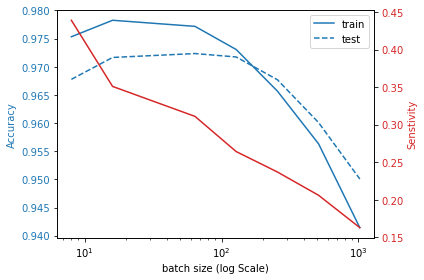

In [10]:
fig, ax1 = plt.subplots()
alpha=[8,16,64,128,256,512,1024]
color = 'tab:blue'
ax1.set_xlabel('batch size (log Scale)')
ax1.set_xscale('log')

ax1.set_ylabel('Accuracy', color=color)
ax1.plot(alpha, training_accuracy_array, color=color,label="train")
ax1.plot(alpha, testing_accuracy_array, '--', color=color,label="test")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Senstivity', color=color)  # we already handled the x-label with ax1
ax2.plot(alpha,sensitivty_array,color=color,label="senstivity")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig("Sen_accuracy.png")

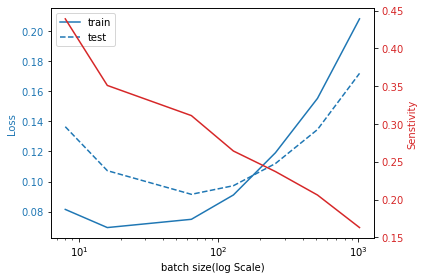

In [11]:
fig, ax1 = plt.subplots()
alpha=[8,16,64,128,256,512,1024]
color = 'tab:blue'
ax1.set_xlabel('batch size(log Scale)')
ax1.set_xscale('log')

ax1.set_ylabel('Loss', color=color)
ax1.plot(alpha, training_loss_array, color=color,label="train")
ax1.plot(alpha, testing_loss_array, '--', color=color,label="test")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Senstivity', color=color)  # we already handled the x-label with ax1
ax2.plot(alpha,sensitivty_array,color=color,label="senstivity")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig("Sen_loss.png")